# Milestone II

In [2]:
import pandas as pd
import numpy as np
import re
import pickle
import string
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
import nltk
from collections import Counter
from textstat import textstat
from sklearn.utils import resample
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

# NLTK imports
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# NLTK downloads
nltk.download("punkt")
nltk.download("stopwords")
nltk.download("vader_lexicon")

# Ignore warnings
warnings.filterwarnings('ignore')


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Robert\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Robert\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Robert\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [31]:
df = pd.read_csv("YoutubeCommentsDataSet_Balanced.csv")
df.head()

,Comment,Sentiment,Comment_preprocessed
0,the creator of monopoly would be speechless ab...,negative,creator monopoly speechless
1,sometimes im just taking my test and the voice...,negative,taking test voice scare loooool coming
2,even when andy isnt trying to be a genius he is,neutral,andy genius
3,its just usual trimming of the fluff when exce...,neutral,usual trimming fluff excess liquidity withdraw...
4,mom wake your ass up for classes me oh nah nah...,negative,mom wake as class meeting bed


Ramka df zawiera kolumny Comment, Sentiment oraz Comment_preprocessed. Zbiór ten jest zbalansowany pod względem sentymentów, oczysczony i pozbawiony duplikatów.
Comment_preprocessed zawiera komentarze z usuniętymi stopwords. Pozostawiłyśmy kolumnę Comment bez zmian, gdyż będziemy jej potrzebować do stworzenia niektórych cech  istotnych w budowie modelu.

# Inżynieria cech

W kontekście naszych danych stwierdziłyśmy, że przydatne będą następujące cechy:
- Sentiment_Score_nltk (ciągły wskaźnik sentymentu komentarza o warotściach [-1, 1])
- Comment_length (długość komentarza)
- Starts_with_i (czy komentarz zaczyna się od I)
- Personal_Pronoun_count (liczba zaimków osobowych, takich jak he, she, i, etc.)
- Number_of_phrases (czyli podział komentarza według spójników "but", "and", "because")
- Avg_phrase_length (średnia długość frazy)
- Number_of_words (liczba słów)
- Avg_word_length (średnia długość słów)
- Unique_word_ratio (stosunek liczby unikalnych słów do wszystkich słów, im większa tym bardziej rozbudowane słownictwo)
- Readibility_Score (wskaźnik czytelności tekstu mierzony za pomocą Flesch Reading Ease)
- Negation_Count (ilość negacji w komentarzu, czyli słów, które wprowadzają zaprzeczenie np. "not","never","nobody","dont" itp.)
- Rare_Word_Count (Liczenie rzadkich słów na podstawie ich częstotliwości w całym zbiorze danych)


### Zmienna Sentiment_Score_nltk

In [32]:
# Funkcja do obliczania Sentiment Score za pomocą NLTK
sia = SentimentIntensityAnalyzer()
def sentiment_score(comment):
    return sia.polarity_scores(comment)['compound']

### Zmienna Personal_Pronun_Count

In [33]:
# Funkcja do liczenia liczby zaimków osobistych
personal_pronouns = {"i", "me", "my", "mine", "myself", "we", "us", "our", "ours", "ourselves",
                     "you", "your", "yours", "yourself", "yourselves", "he", "him", "his", "himself",
                     "she", "her", "hers", "herself", "it", "its", "itself", "they", "them", "their",
                     "theirs", "themselves"}

def count_personal_pronouns(comment):
    words = word_tokenize(comment.lower())
    return sum(1 for word in words if word in personal_pronouns)

### Zmienne Number_of_phrases, Number_of_words, Avg_phrase_length, Avg_word_length, Unique_word_ratio

In [34]:
# Funkcja do analizy złożoności zdań (np. liczba fraz, słów)
connectors = ["and", "but", "so", "because", "which", "that", "then", "if", "or"]
def sentence_complexity(comment):
    words = word_tokenize(comment)
    phrases = re.split(r'\b(?:' + '|'.join(connectors) + r')\b', comment)

    num_words = len(words)
    num_phrases = len(phrases)

    avg_word_length = np.mean([len(word) for word in words]) if words else 0
    avg_phrase_length = num_words / num_phrases if num_phrases > 0 else 0
    unique_word_ratio = len(set(words)) / num_words if num_words > 0 else 0

    return {
        "Number_of_phrases": num_phrases,
        "Number_of_words": num_words,
        "Avg_phrase_length": avg_phrase_length,
        "Avg_word_length": avg_word_length,
        "Unique_word_ratio": unique_word_ratio
    }


### Zmienna Readability_Score

In [35]:
# Funkcja do obliczania readability score
def readability_score(comment):
    return textstat.flesch_reading_ease(comment)

### Zmienna Negation_Count

In [36]:
# Funkcja do liczenia negacji
def negation_count(comment):
    negations = {"not", "never", "no", "none", "cannot", "nothing","dont","nah",'wont','cant','doesnt','shouldnt',"shouldn't","doesn't"
                 "don't","won't","wouldn't", "can't","nobody",'neither','nope',"ain't","nowhere",'wouldnt'}
    words = word_tokenize(comment.lower())
    return sum(1 for word in words if word in negations)

### Zmienna Rare_Word_Count

In [37]:
# Funkcja do liczenia rzadkich słów
def rare_word_count(comment, all_words):
    words = word_tokenize(comment.lower())
    rare_words = [word for word in words if all_words[word] < 10]  # Możemy dostosować próg (tutaj <10)
    return len(rare_words)

### Embedding

In [38]:
# Function to apply TF-IDF embedding on preprocessed comments
def apply_tfidf(df):
    tfidf = TfidfVectorizer(max_features=300)
    tfidf_matrix = tfidf.fit_transform(df['Comment_preprocessed']).toarray()
    tfidf_df = pd.DataFrame(tfidf_matrix, columns=[f"tfidf_{i}" for i in range(tfidf_matrix.shape[1])])
    
    return pd.concat([df.reset_index(drop=True), tfidf_df], axis=1)

Przygotowujemy cechy:

In [ ]:
# Funkcja do przygotowania cech
def prepare_features(df):
    # Dodajemy cechy do DataFrame
    df['Sentiment_Score_nltk'] = df['Comment'].apply(sentiment_score)
    df['Starts_with_i'] = df['Comment'].str.startswith("i")
    df['Comment_Length'] = df['Comment'].str.len()
    
    sentiment_mapping = {'negative': -1, 'neutral': 0, 'positive': 1}
    df['Sentiment_num'] = df['Sentiment'].map(sentiment_mapping)

    df["Personal_Pronoun_count"] = df["Comment"].apply(count_personal_pronouns)
    df["Readability_Score"] = df["Comment"].apply(readability_score)
    df["Negation_Count"] = df["Comment"].apply(negation_count)

    df_complexity = df["Comment"].apply(lambda x: sentence_complexity(x))
    df_complexity = pd.DataFrame(df_complexity.tolist())
    df = pd.concat([df, df_complexity], axis=1)

    # Liczenie rzadkich słów
    all_words = Counter(' '.join(df['Comment']).lower().split())
    df['Rare_Word_Count'] = df['Comment'].apply(lambda x: rare_word_count(x, all_words))



    return df

Budujemy pipeline:

In [40]:
def build_feature_pipeline():
    preprocessor = ColumnTransformer(
        transformers=[
            ("text_features", FunctionTransformer(prepare_features), ['Comment']),
            # ("tfidf_features", FunctionTransformer(apply_tfidf), ['Comment_preprocessed'])
        ]
    )

    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor)
    ])
    
    return pipeline

# Tworzenie i zapisanie pipeline
pipeline = build_feature_pipeline()

with open("feature_pipeline.pkl", "wb") as file:
    pickle.dump(pipeline, file) 

Aplikujemy wszystkie features na naszym zbiorze:

In [41]:
df = prepare_features(df)
df.head()

,Comment,Sentiment,Comment_preprocessed,Sentiment_Score_nltk,Starts_with_i,Comment_Length,Sentiment_num,Personal_Pronoun_count,Readability_Score,Negation_Count,Number_of_phrases,Number_of_words,Avg_phrase_length,Avg_word_length,Unique_word_ratio,Rare_Word_Count
0,the creator of monopoly would be speechless ab...,negative,creator monopoly speechless,0.0000,False,58,-1,0,52.87,0,1,10,10.000000,4.900000,1.000000,0
1,sometimes im just taking my test and the voice...,negative,taking test voice scare loooool coming,0.0258,False,98,-1,2,86.03,0,3,19,6.333333,4.210526,0.947368,1
2,even when andy isnt trying to be a genius he is,neutral,andy genius,0.0000,False,47,0,1,68.77,0,1,11,11.000000,3.363636,1.000000,1
3,its just usual trimming of the fluff when exce...,neutral,usual trimming fluff excess liquidity withdraw...,0.2023,True,218,0,4,53.21,0,5,43,8.600000,4.093023,0.813953,9
4,mom wake your ass up for classes me oh nah nah...,negative,mom wake as class meeting bed,-0.7579,False,88,-1,3,92.46,5,1,21,21.000000,3.238095,0.809524,0


## Macierz korelacji

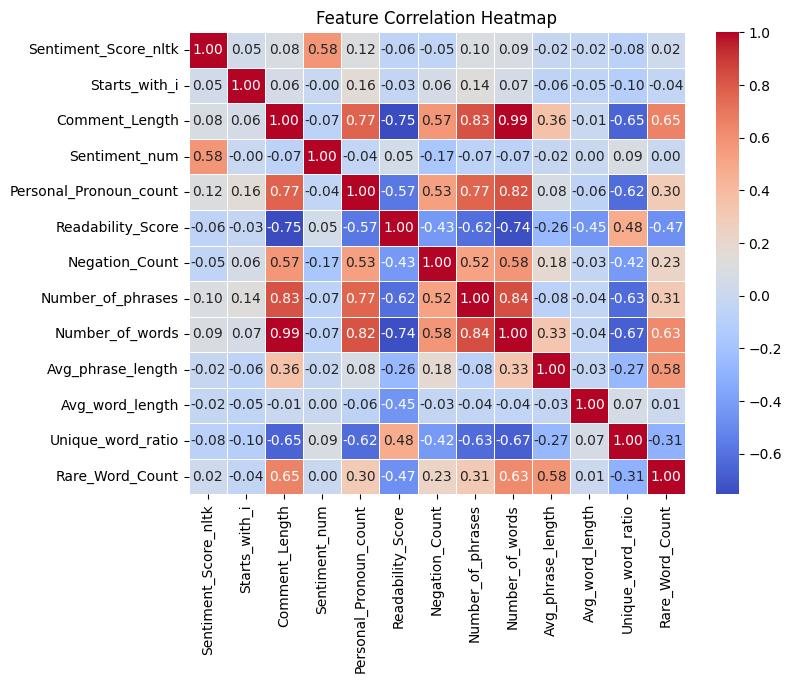

In [42]:
corr_matrix = df.drop(columns=["Comment", "Sentiment","Comment_preprocessed"]).corr()

plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()

Widać, że zmienne Number_of_words, Number_of_phrases i Comment_Length są silnie skorelowane, dlatego pod uwagę weźniemy tylko cechę Comment_Length.

In [ ]:
# Usuwamy silnie skorelowane zmienne
df.drop(columns=['Number_of_words', 'Number_of_phrases'], inplace=True)
df.head()

,Comment,Sentiment,Comment_preprocessed,Sentiment_Score_nltk,Starts_with_i,Comment_Length,Sentiment_num,Personal_Pronoun_count,Readability_Score,Negation_Count,Avg_phrase_length,Avg_word_length,Unique_word_ratio,Rare_Word_Count
0,the creator of monopoly would be speechless ab...,negative,creator monopoly speechless,0.0000,False,58,-1,0,52.87,0,10.000000,4.900000,1.000000,0
1,sometimes im just taking my test and the voice...,negative,taking test voice scare loooool coming,0.0258,False,98,-1,2,86.03,0,6.333333,4.210526,0.947368,1
2,even when andy isnt trying to be a genius he is,neutral,andy genius,0.0000,False,47,0,1,68.77,0,11.000000,3.363636,1.000000,1
3,its just usual trimming of the fluff when exce...,neutral,usual trimming fluff excess liquidity withdraw...,0.2023,True,218,0,4,53.21,0,8.600000,4.093023,0.813953,9
4,mom wake your ass up for classes me oh nah nah...,negative,mom wake as class meeting bed,-0.7579,False,88,-1,3,92.46,5,21.000000,3.238095,0.809524,0


Aplikujemy embedding.

In [44]:
# TF-IDF Embeddings**
tfidf = TfidfVectorizer(max_features=300)
tfidf_matrix = tfidf.fit_transform(df['Comment']).toarray()
tfidf_df = pd.DataFrame(tfidf_matrix, columns=[f"tfidf_{i}" for i in range(tfidf_matrix.shape[1])])
    
df = pd.concat([df.reset_index(drop=True), tfidf_df], axis=1)

# Wybór modelu